In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', 100) # Setting pandas to display a N number of columns
pd.set_option('display.max_rows', 10) # Setting pandas to display a N number rows
pd.set_option('display.width', 100) # Setting pandas dataframe display width to N
import matplotlib.pyplot as plt # plotting library
from src.utils import import_data, categorial_feature_overview
import ppscore as pps # importing ppscore
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [6]:
file = "usersessions/train.json"
df = import_data(file)

Memory usage of dataframe is 13.73 MB
Memory usage after optimization is: 10.36 MB
Decreased by 24.6%


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   browser      60000 non-null  object        
 1   os           60000 non-null  object        
 2   locale       60000 non-null  object        
 3   gender       60000 non-null  object        
 4   time         60000 non-null  object        
 5   country      60000 non-null  object        
 6   city         60000 non-null  object        
 7   date_hour    60000 non-null  datetime64[ns]
 8   dayofweek    60000 non-null  int8          
 9   day          60000 non-null  int8          
 10  month        60000 non-null  int8          
 11  year         60000 non-null  int16         
 12  hour         60000 non-null  float16       
 13  hour_fixed   60000 non-null  float16       
 14  sites_num    60000 non-null  int8          
 15  session_len  60000 non-null  float16       
 16  site

In [7]:
(df.is_joe==1).sum() / len(df) * 100

0.49

<AxesSubplot:>

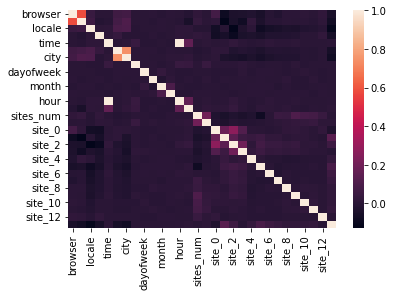

In [8]:
sns.heatmap(df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 

<AxesSubplot:xlabel='x', ylabel='y'>

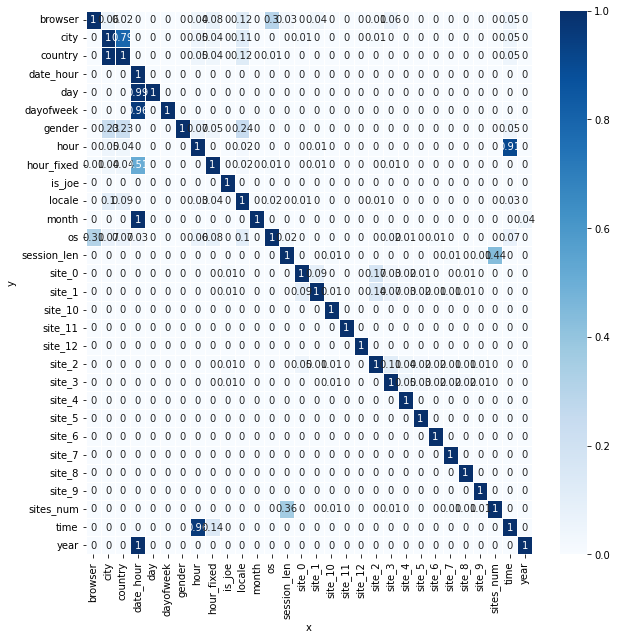

In [9]:
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
matrix_df = matrix_df.apply(lambda x: round(x, 2)) # Rounding matrix_df's values to 0,XX
_, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches


sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.75, annot=True, ax=ax)

PPS matrix presents non-linear relationships between variables. 

- High value for relationship between location and both, city and country.
- Relatively high value between os and browser.
- High value between sites_num and session_len

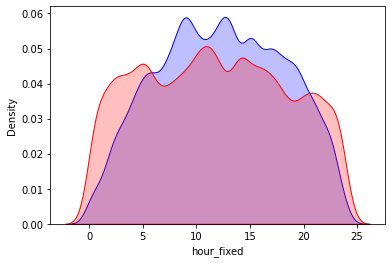

In [10]:
sns.kdeplot(df["hour_fixed"], shade=1, color='blue')
sns.kdeplot(df["hour"], shade=1, color='red')
plt.show()

fixing timezones drastically changed distribution of hours. 

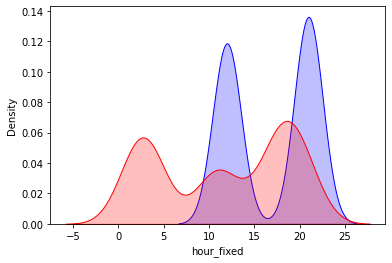

In [11]:
sns.kdeplot(x= df[df['is_joe'] == 1]["hour_fixed"], shade=1, color='blue')
sns.kdeplot(x= df[df['is_joe'] == 1]["hour"], shade=1, color='red')
plt.show()

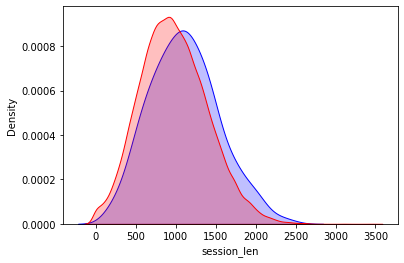

In [14]:
sns.kdeplot(x= df[df['is_joe'] == 1]["session_len"], shade=1, color='blue')
sns.kdeplot(x= df[df['is_joe'] == 0]["session_len"], shade=1, color='red')
plt.show()

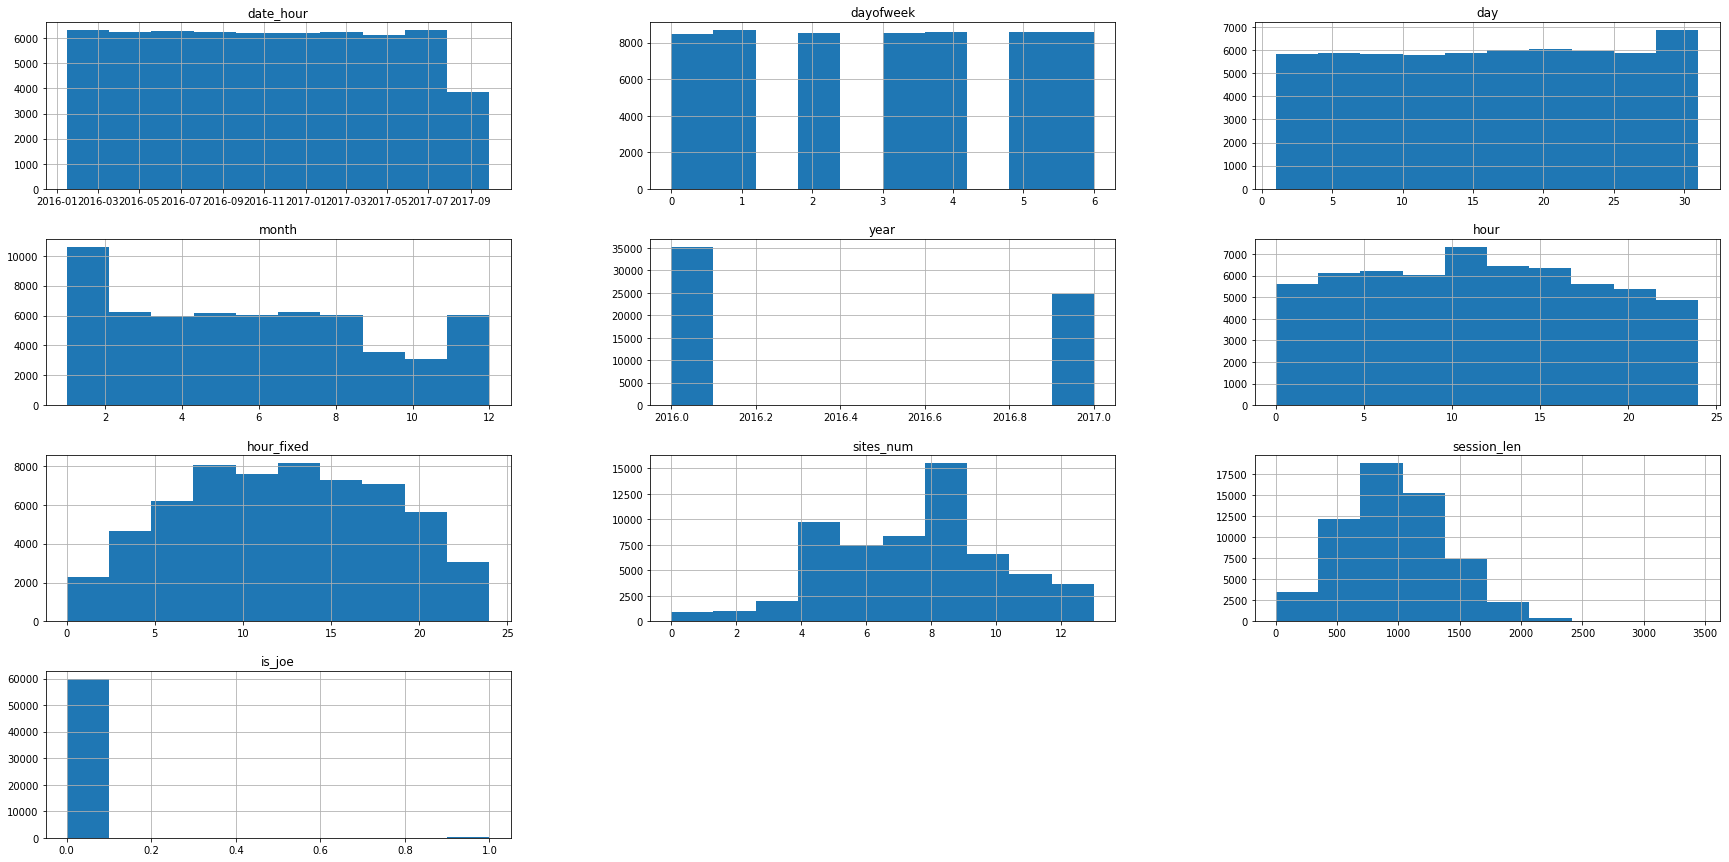

In [15]:
df.hist(figsize=(30,15))
plt.show()


In [16]:
num_categorical = ['month', 'year', 'dayofweek']
for i in num_categorical:
  print(i, df[i].unique())

month [ 1 10  3  2  8 11  7  5  4  6 12  9]
year [2017 2016]
dayofweek [6 2 1 0 4 5 3]


In [17]:
cont_cols = df.select_dtypes(include=[np.number]).drop(num_categorical, axis=1).columns

In [18]:
data = pd.melt(df, value_vars=cont_cols)
data.head()


,variable,value
0,day,8.0
1,day,5.0
2,day,28.0
3,day,9.0
4,day,28.0


In [19]:
data

,variable,value
0,day,8.0
1,day,5.0
2,day,28.0
3,day,9.0
4,day,28.0
...,...,...
359995,is_joe,0.0
359996,is_joe,0.0
359997,is_joe,0.0
359998,is_joe,0.0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

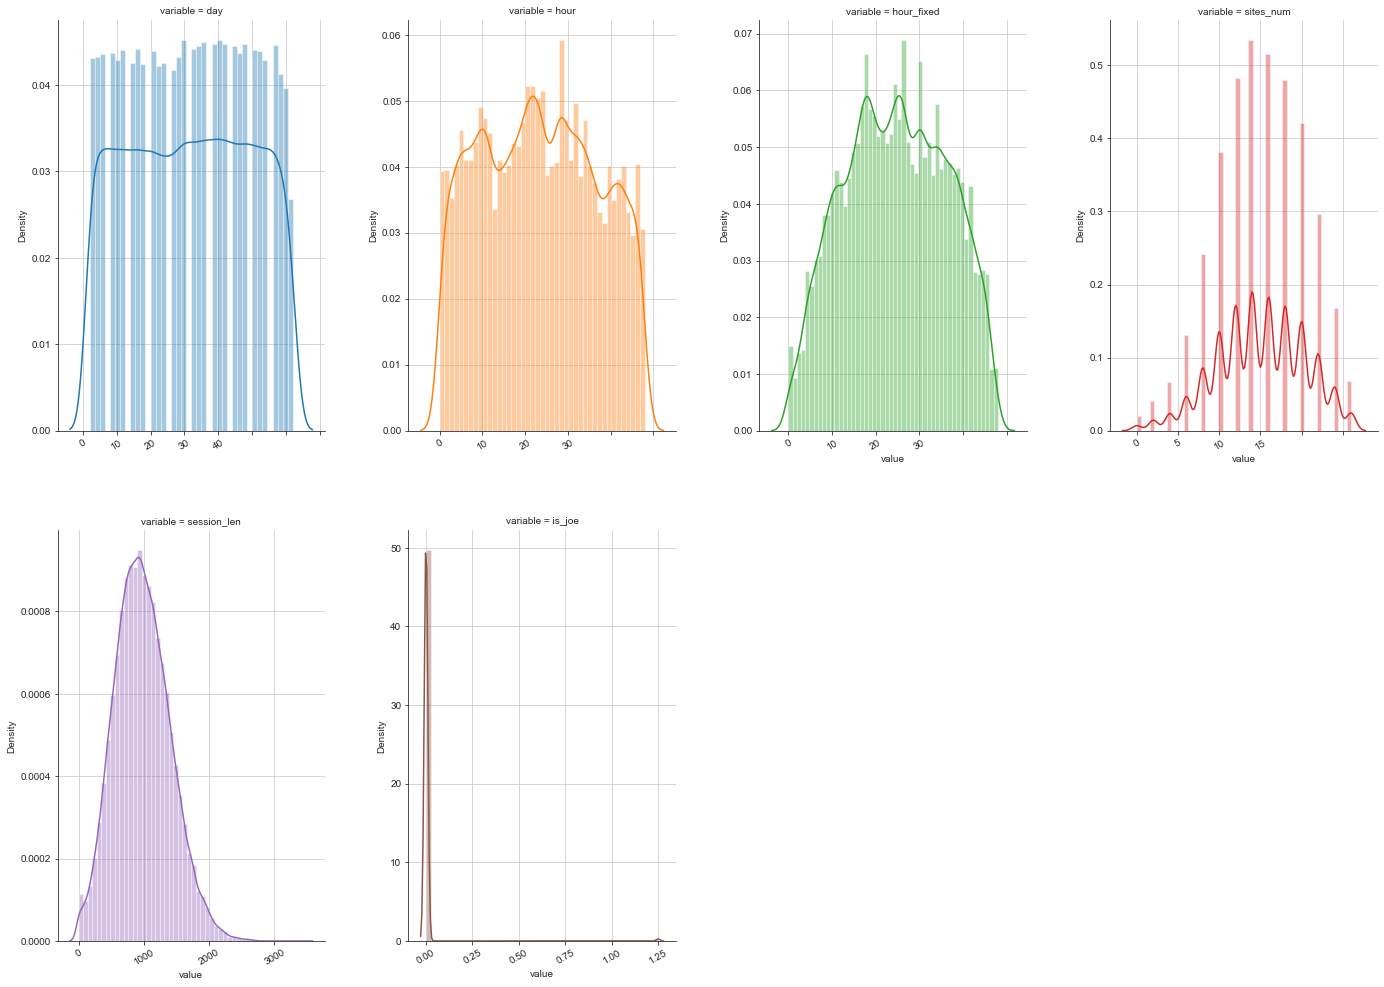

In [20]:
#Using col_wrap - we have one row. Plotting all continous numerical cols
sns.set_style('ticks', {'axes.grid': True})
plots = sns.FacetGrid(data, col='variable', col_wrap=4, sharex=False, sharey=False, hue='variable')
plots = plots.map(sns.distplot,'value')
for axes in plots.axes.flat:
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
plt.gcf().set_size_inches(20,15)

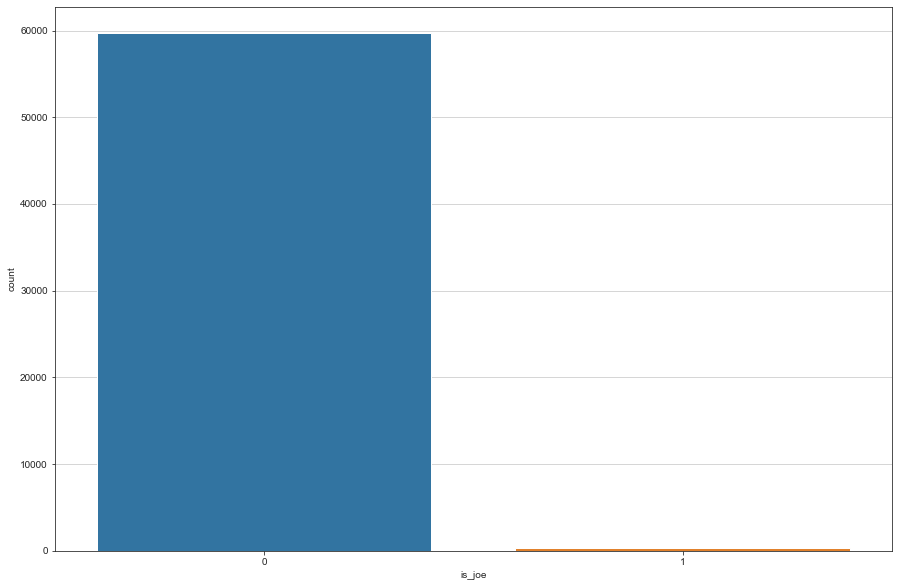

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(data=df, x='is_joe')
plt.show()

In [ ]:
cat_cols = df.select_dtypes(object).columns
joe = df[df['is_joe']==1]

<AxesSubplot:xlabel='locale', ylabel='count'>

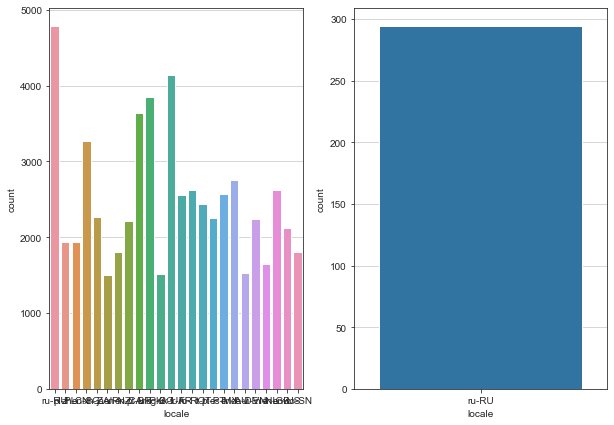

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
sns.countplot(data=df, x='locale', ax=ax[0])
sns.countplot(data=joe, x='locale', ax=ax[1])


<AxesSubplot:xlabel='browser', ylabel='count'>

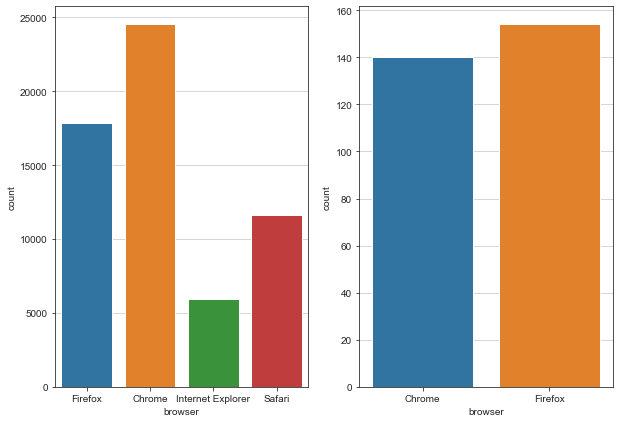

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
sns.countplot(data=df, x='browser', ax=ax[0])
sns.countplot(data=joe, x='browser', ax=ax[1])


<AxesSubplot:xlabel='gender', ylabel='count'>

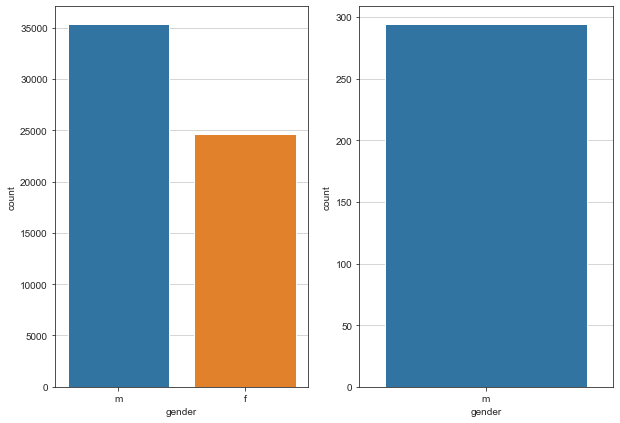

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
sns.countplot(data=df, x='gender', ax=ax[0])
sns.countplot(data=joe, x='gender', ax=ax[1])


<AxesSubplot:xlabel='os', ylabel='count'>

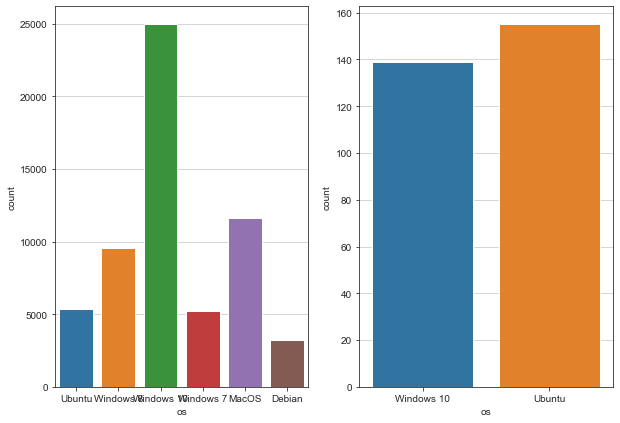

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
sns.countplot(data=df, x='os', ax=ax[0])
sns.countplot(data=joe, x='os', ax=ax[1])


<AxesSubplot:xlabel='country', ylabel='count'>

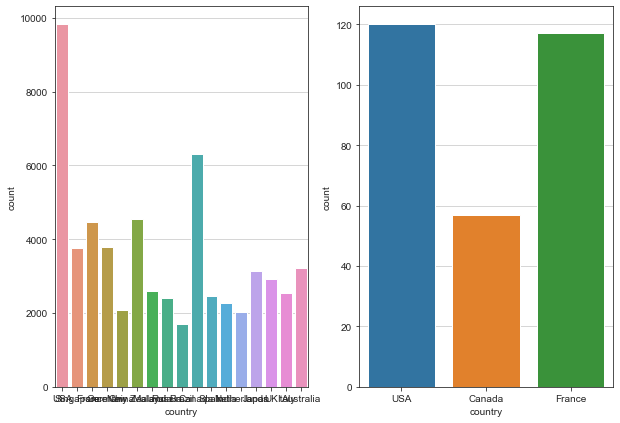

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
sns.countplot(data=df, x='country', ax=ax[0])
sns.countplot(data=joe, x='country', ax=ax[1])


<AxesSubplot:xlabel='dayofweek', ylabel='count'>

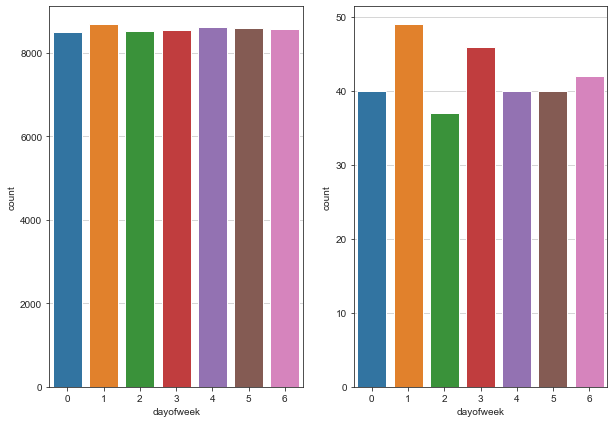

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
sns.countplot(data=df, x='dayofweek', ax=ax[0])
sns.countplot(data=joe, x='dayofweek', ax=ax[1])


<AxesSubplot:xlabel='year', ylabel='count'>

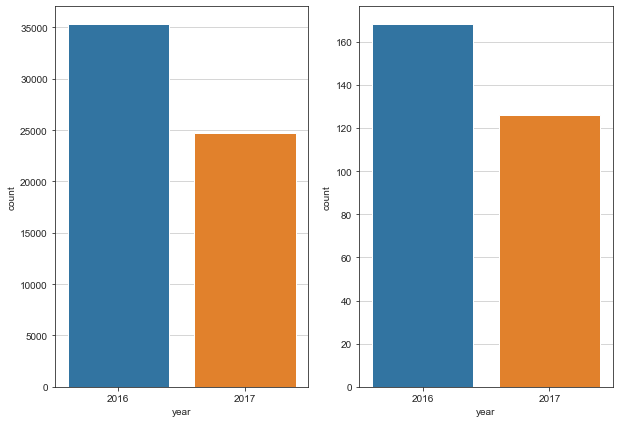

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
sns.countplot(data=df, x='year', ax=ax[0])
sns.countplot(data=joe, x='year', ax=ax[1])



In [ ]:
cat_cols

Index(['browser', 'os', 'locale', 'gender', 'time', 'country', 'city', 'site_0', 'site_1',
       'site_2', 'site_3', 'site_4', 'site_5', 'site_6', 'site_7', 'site_8', 'site_9', 'site_10',
       'site_11', 'site_12'],
      dtype='object')

browser has 0.0 % of null values


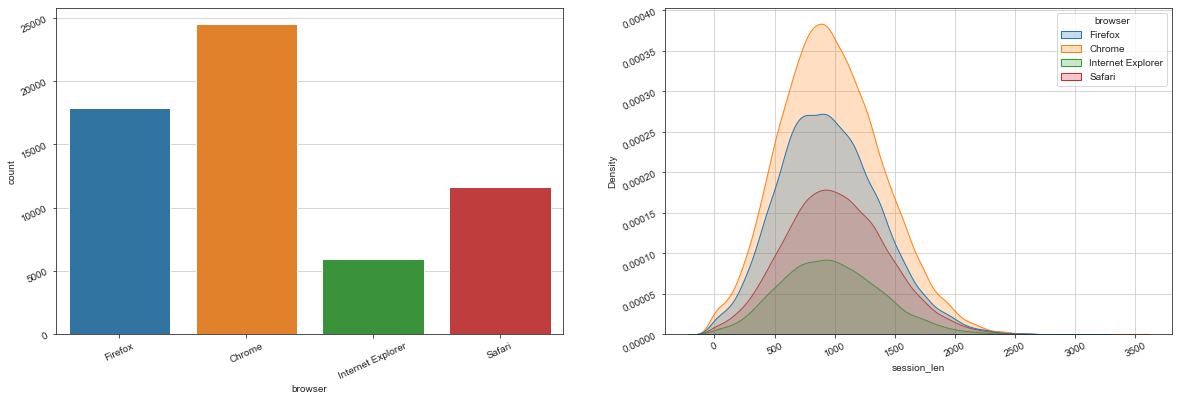

os has 0.0 % of null values


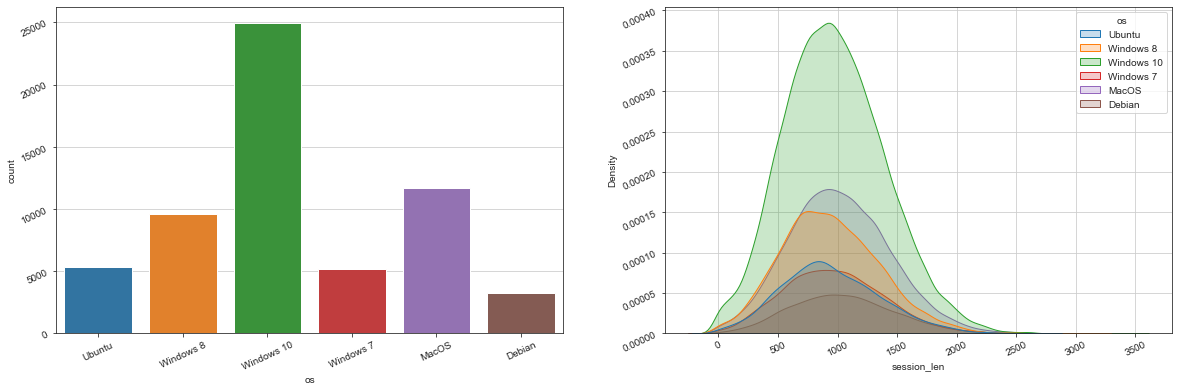

locale has 0.0 % of null values


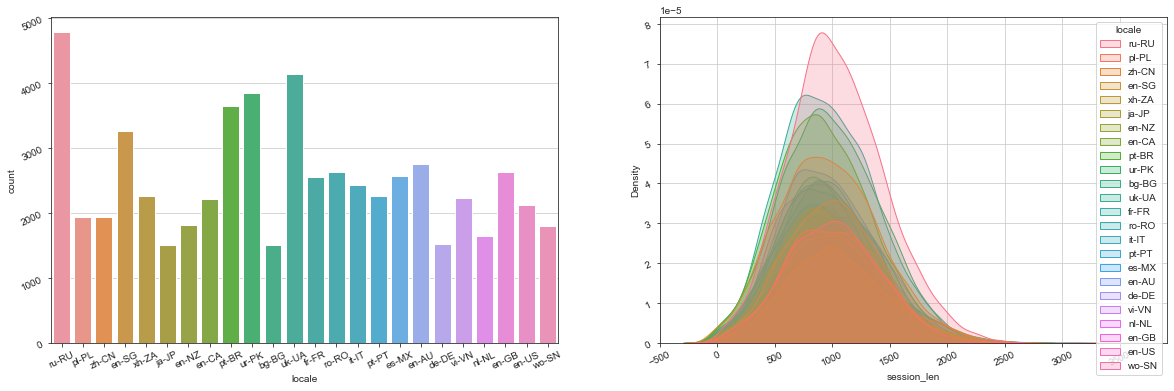

gender has 0.0 % of null values


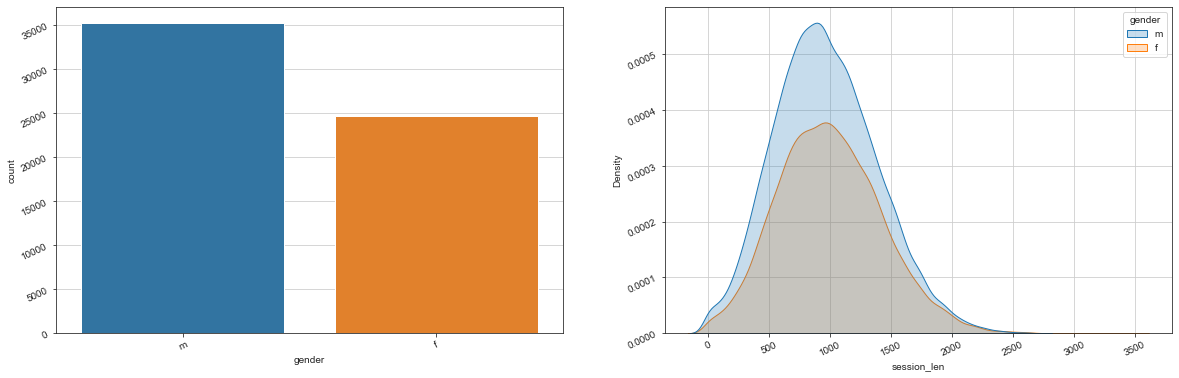

country has 0.0 % of null values


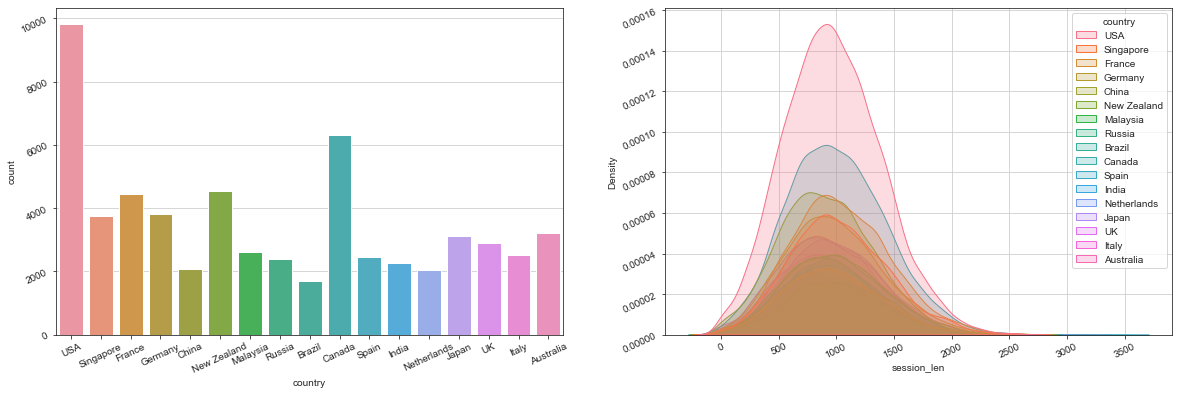

city has 0.0 % of null values


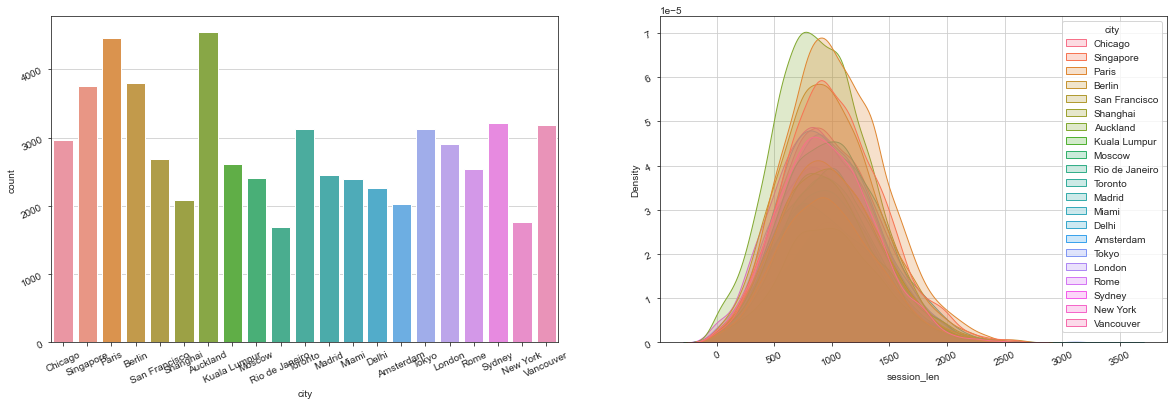

site_0 has 0.0 % of null values


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


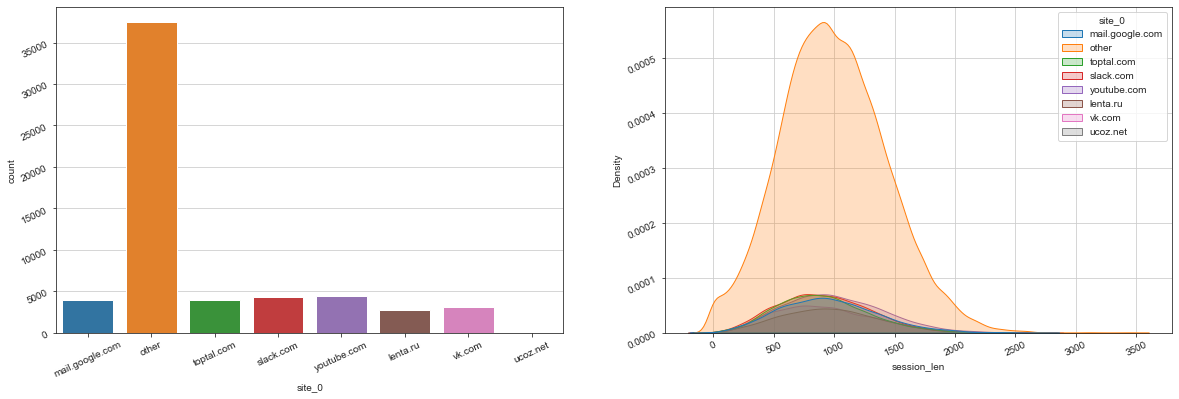

site_1 has 0.0 % of null values


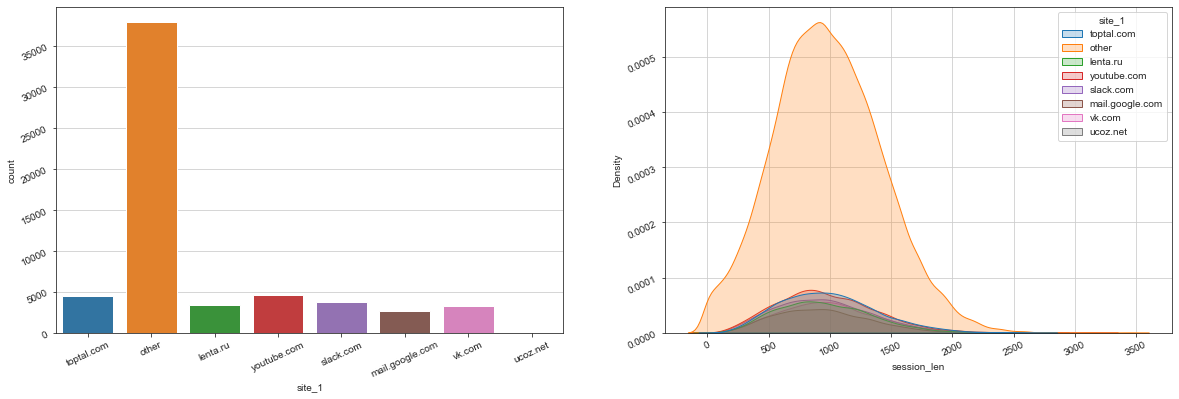

site_2 has 0.0 % of null values


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


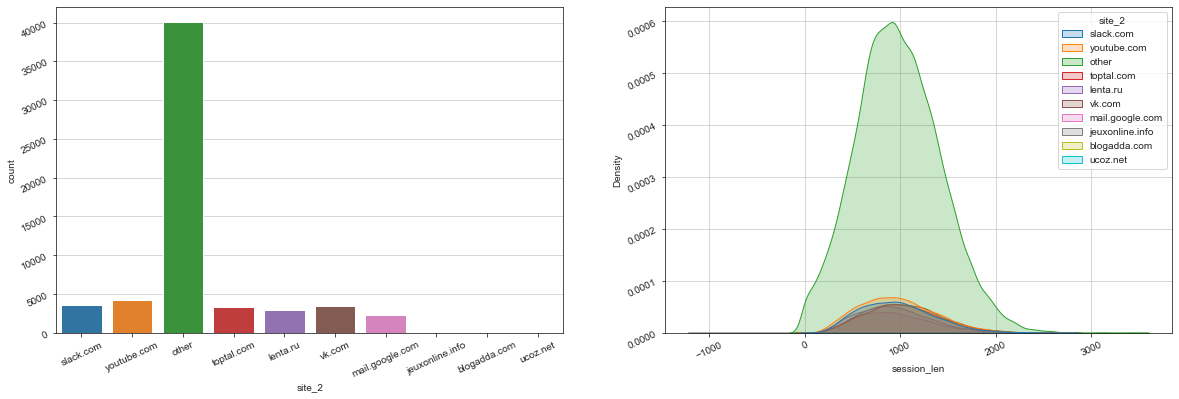

site_3 has 0.0 % of null values


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


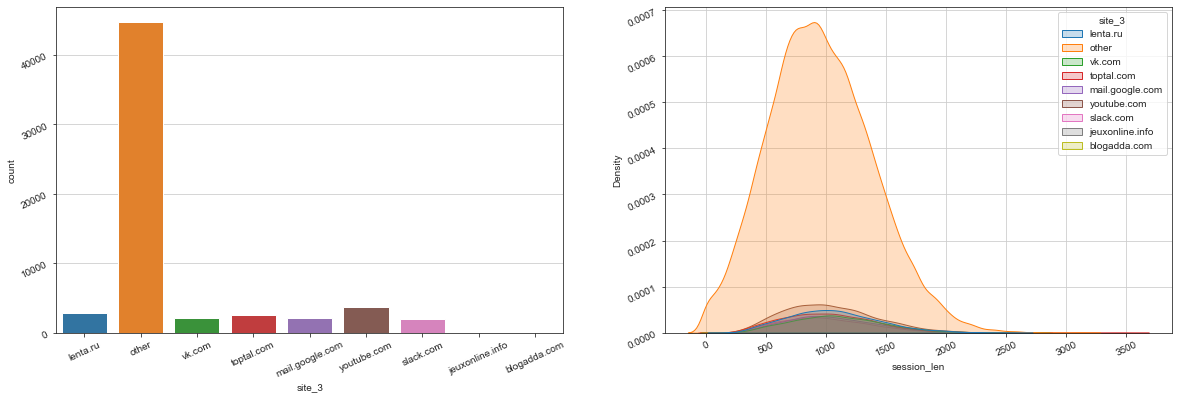

site_4 has 0.0 % of null values


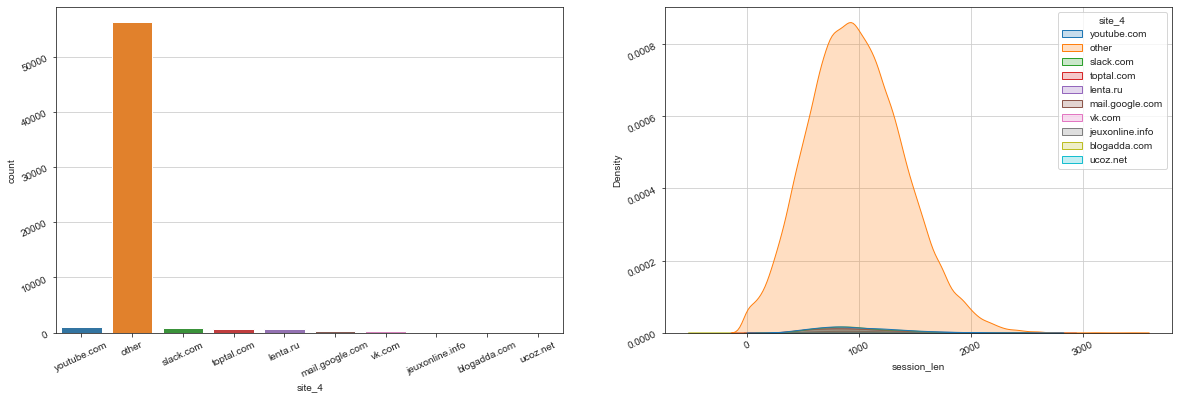

site_5 has 0.0 % of null values


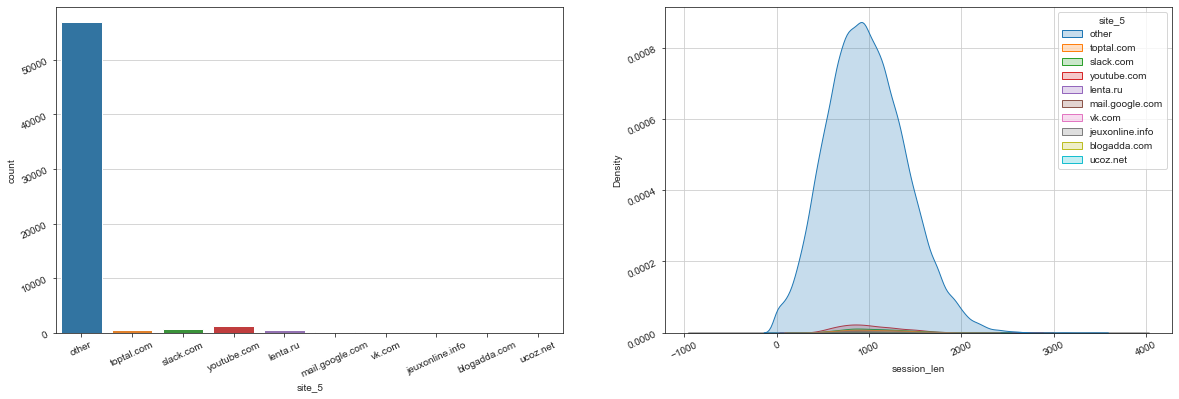

site_6 has 0.0 % of null values


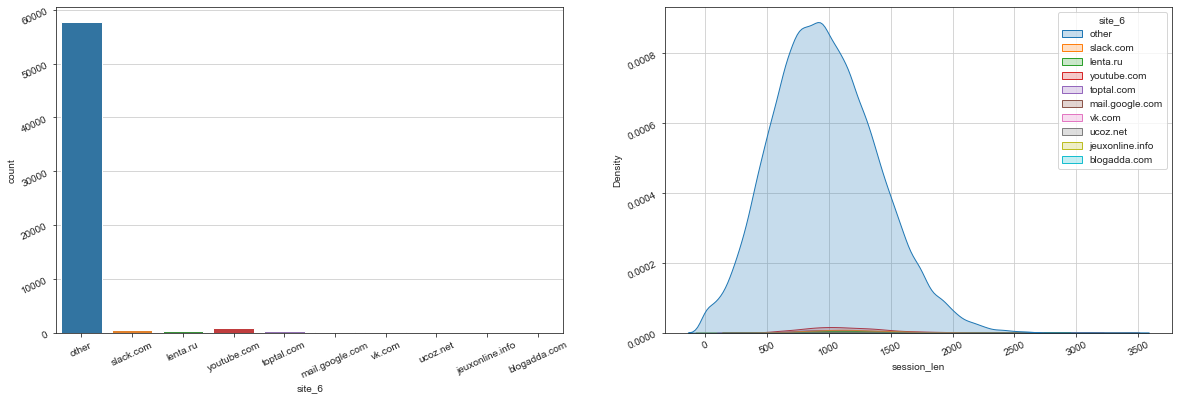

site_7 has 0.0 % of null values


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


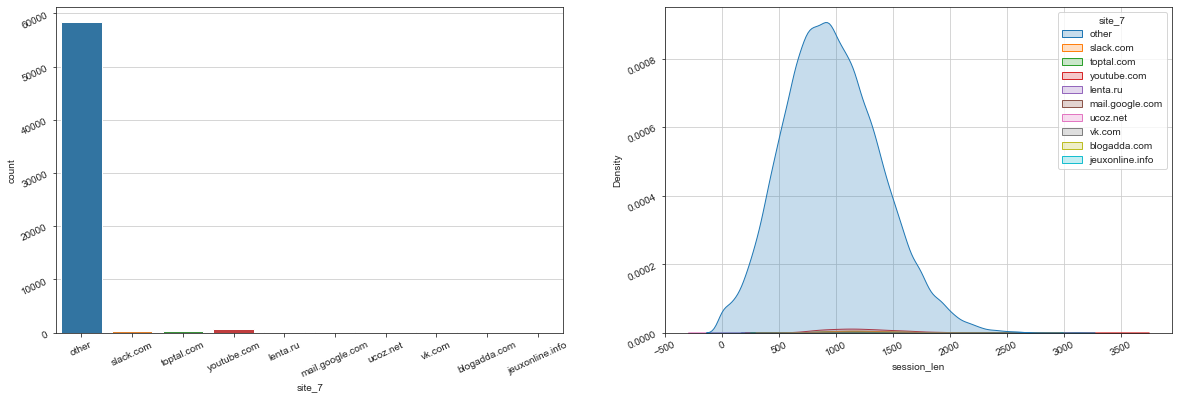

site_8 has 0.0 % of null values


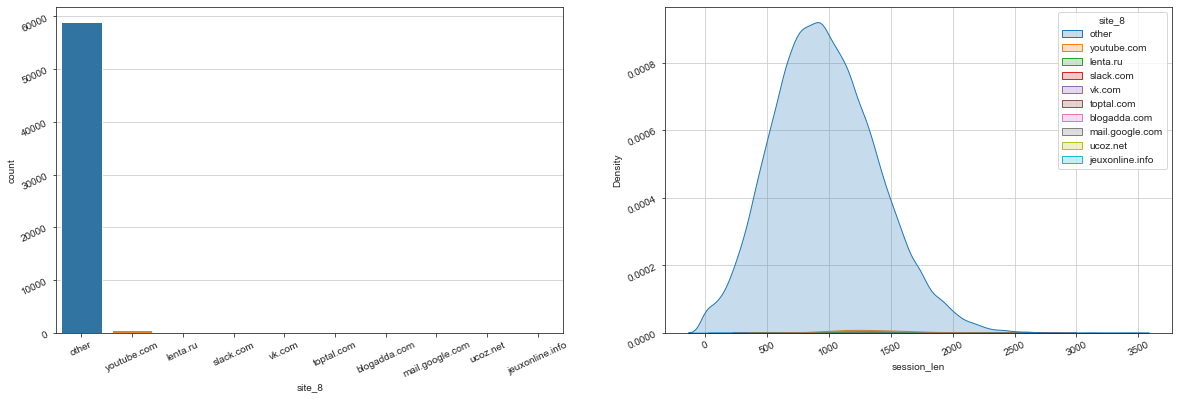

site_9 has 0.0 % of null values


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


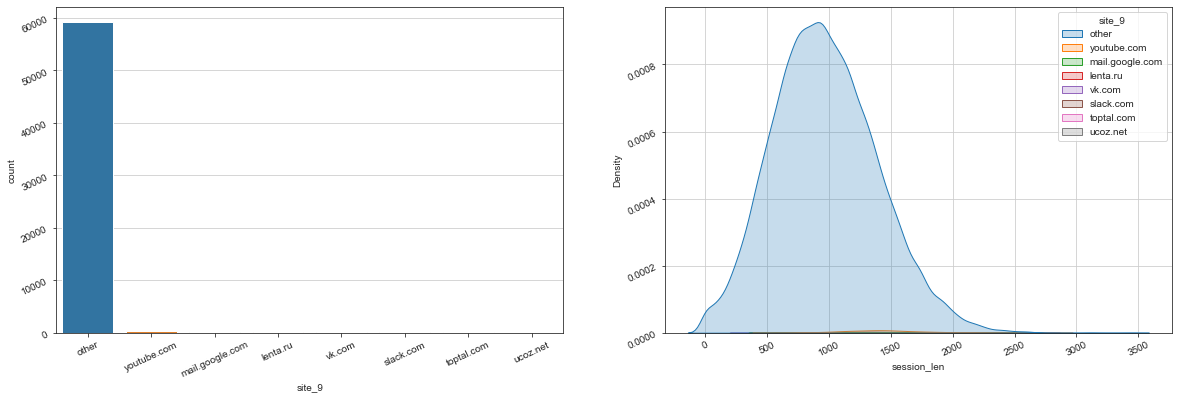

site_10 has 0.0 % of null values


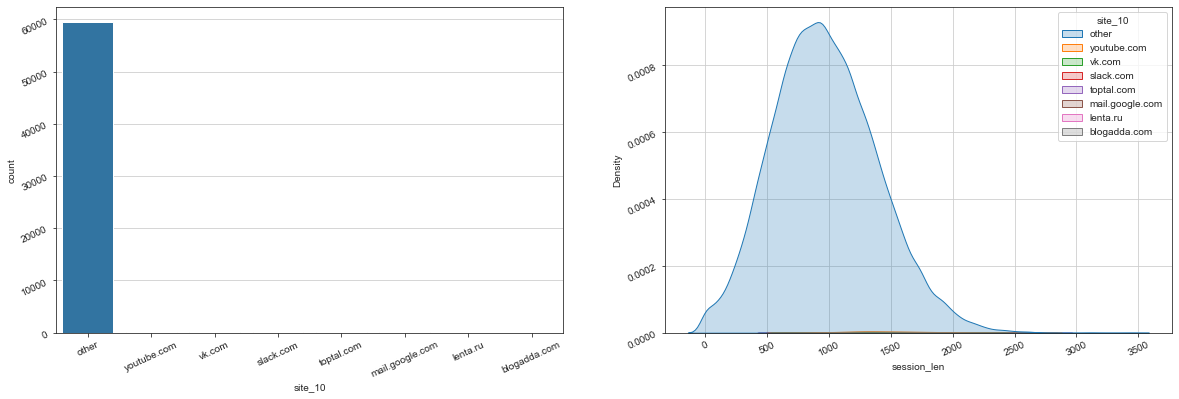

site_11 has 0.0 % of null values


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


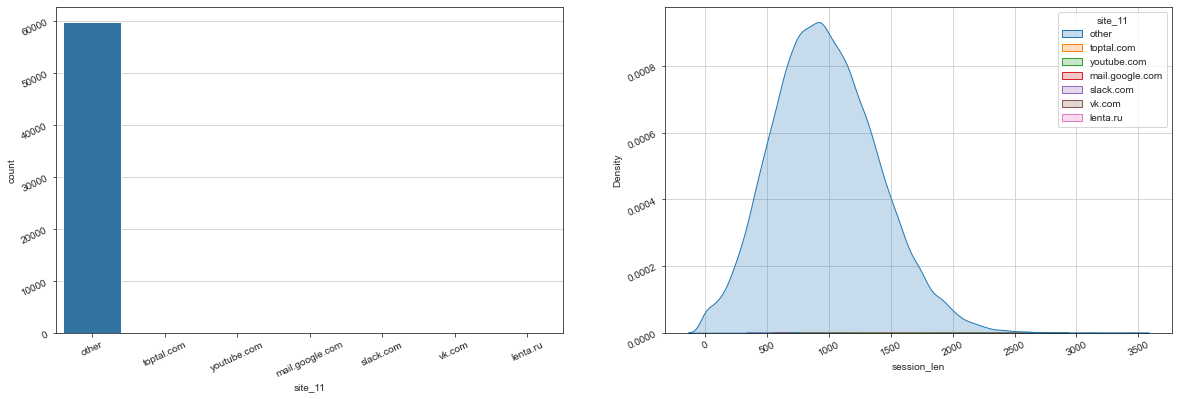

site_12 has 0.0 % of null values


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


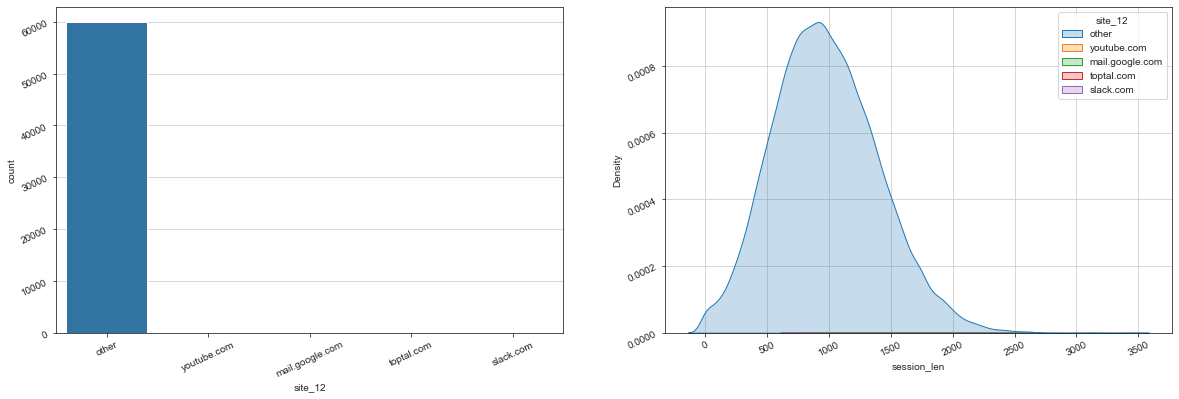

In [ ]:
for col in cat_cols.drop('time'):
    categorial_feature_overview(col, 25, df)